In [49]:
%reset
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import defmod as dm
import multimodule_usefulfunctions as mm 
import hamiltonian_multishape as ham
import kernels as ker

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
## define reference and template shape
r = [3,2]
origin1 = [[0,0], [6,6]]
origin2 = [[0,3], [6,4]]
nb_points = [10,7]

source = mm.multipleCircles(origin1, r ,nb_points)
target = mm.multipleCircles(origin2, r ,nb_points)

In [51]:
source[0].requires_grad


True

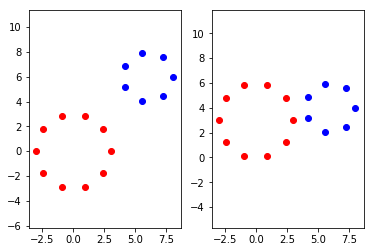

In [52]:
plt.subplot(1,2,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.subplot(1,2,2)
plt.scatter(target[0][:, 0].detach().numpy(), target[0][:, 1].detach().numpy(), c='red')
plt.scatter(target[1][:, 0].detach().numpy(), target[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()

In [53]:
## Define Deformation Modules
dim = 2
nb_shapes = 2

# Module 1: Translation of first circle
sigma1 = 10
nb_pts1 = 1
trans1 = dm.deformationmodules.Translations(dim, nb_pts1, sigma1)

# Module 2: Translation of second circle
sigma2 = 10
nb_pts2 = 1
trans2 = dm.deformationmodules.Translations(dim, nb_pts2, sigma2)

# Module 3: Background Module
sigma3 = 1.5
nb_pts = nb_points[0] + nb_points[1]
background = dm.deformationmodules.Translations(dim, nb_pts, sigma3)


module_list = [trans1, trans2, background]
dim_controls = dim*(1+1+nb_pts)

In [54]:
mm.computeCenter(source[1])


tensor([6., 6.], grad_fn=<MeanBackward0>)

In [107]:
sigma = [sigma1, sigma2, sigma3]
z = [mm.computeCenter(source[0]), mm.computeCenter(source[1])]

#initialize gd and momentum
mom_tmp0 = np.zeros([nb_points[0], dim])
mom_tmp0[:,1] = 10.
mom_tmp1 = np.zeros([nb_points[1], dim])
mom_tmp1[:,1] = -10.
gd_list = [source[0], source[1], torch.cat([source[0], source[1]],0)]
mom_list = [torch.tensor(mom_tmp0.copy(), requires_grad=True, dtype=torch.float32), torch.tensor(mom_tmp1.copy(),requires_grad=True, dtype=torch.float32), torch.tensor(np.zeros(gd_list[2].shape),requires_grad=True, dtype=torch.float32)]

# compute geodesic control and lagrange multiplier
l_list = mm.lambda_qp(gd_list, mom_list, sigma, z, dim)
controls_list = mm.h_qp(gd_list, mom_list, l_list, sigma, z, dim)

# Constraints (identity)
Constr1 = torch.cat([torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]]), -torch.eye(nb_points[0]), torch.zeros([nb_points[0], nb_points[1]])], 1)
Constr2 = torch.cat([torch.zeros([nb_points[1], nb_points[0]]), torch.eye(nb_points[1]), torch.zeros([nb_points[1], nb_points[0]]), -torch.eye(nb_points[1]),], 1)
Constr = [Constr1, Constr2]

# reduced Hamiltonian 
dim_control = [controls_list[0].shape, controls_list[1].shape, controls_list[2].shape]
H = ham.Hamiltonian_Multishape(module_list, dim_control)

In [108]:
# cost term of Hamiltonian
H.def_cost(gd_list, controls_list, z)

tensor(2115.4629, grad_fn=<AddBackward0>)

In [109]:
gd_list[2].shape

torch.Size([17, 2])

In [110]:
# applied momentum 
gd_module_list = [*z, gd_list[2]]
H.apply_mom(gd_list, gd_module_list, mom_list, controls_list)

tensor(2105.9783, grad_fn=<AddBackward0>)

In [111]:
# applied constraints term of Hamiltonian
H.apply_constraints(gd_list, gd_module_list, l_list, controls_list, Constr)

tensor(-852.3594, grad_fn=<AddBackward0>)

In [112]:
# Hamiltonian 
H(gd_list, mom_list, controls_list, z, l_list, Constr)

tensor(842.8748, grad_fn=<SubBackward0>)

In [113]:
grad = torch.autograd.grad(H(gd_list, mom_list, controls_list, z, l_list, Constr),[*gd_list, *mom_list], create_graph=True)

In [114]:
speed_gd1 = grad[3]
speed_gd31 = grad[5][0:nb_points[0]]

speed_gd2 = grad[4]
speed_gd32 = grad[5][nb_points[0]:]

In [115]:
gd_final, mom_final = mm.shootMultishape(gd_list, mom_list, H, sigma, dim, n=10)

In [116]:
gd_final[0] - gd_final[2][0:nb_points[0]]
gd_final[1] - gd_final[2][nb_points[0]:]

tensor([[ 0.0000e+00, -2.3842e-07],
        [ 0.0000e+00, -3.5763e-07],
        [ 0.0000e+00, -1.1921e-07],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -4.7684e-07],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00]], grad_fn=<SubBackward0>)

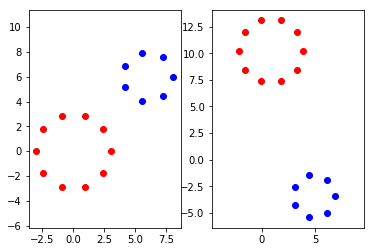

In [117]:
plt.subplot(1,2,1)
plt.scatter(source[0][:, 0].detach().numpy(), source[0][:, 1].detach().numpy(), c='red')
plt.scatter(source[1][:, 0].detach().numpy(), source[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.subplot(1,2,2)
plt.scatter(gd_final[0][:, 0].detach().numpy(), gd_final[0][:, 1].detach().numpy(), c='red')
plt.scatter(gd_final[1][:, 0].detach().numpy(), gd_final[1][:, 1].detach().numpy(), c='blue')

plt.axis('equal')
plt.show()